In [1]:
import math

from sqlalchemy import Column, Integer, MetaData, Table, create_engine, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import select
from sqlalchemy import func

In [2]:
engine = create_engine('postgres://douglas@postgis:5432/AQI', client_encoding='utf8')
Session = sessionmaker(bind=engine)
session = Session()

metadata = MetaData()
metadata.reflect(engine, only=['locs_airlocation', 'locs_airmeasurement'])
Base = automap_base(metadata=metadata)
Base.prepare()

AirLocation, AirMeasurement = Base.classes.locs_airlocation, Base.classes.locs_airmeasurement

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [3]:
# Select some airlocation with bad aqi
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_id = session.execute(s).scalar()
s = select([AirLocation]).where(AirLocation.id == some_airlocation_id)
some_airlocation = session.execute(s).first()
print("{}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
s = select([func.count(AirMeasurement.id)]).where(
    AirMeasurement.airlocation_id == some_airlocation_id
).where(
    AirMeasurement.aqi != None
).where(
    AirMeasurement.aqi != 0
)
some_airlocation_measurement_count = session.execute(s).first()[0]
print("{} AQI measurements for this city".format(some_airlocation_measurement_count))

Mudanjiang, China


37663 AQI measurements for this city


In [4]:
# Collect the measurements for that AirLocation into a
# numpy array like [(min of day, day of year, day of week, day of month, aqi)]
s = select([AirMeasurement.id, AirMeasurement.measurement_datetime, AirMeasurement.aqi]).where(
    AirMeasurement.airlocation_id == some_airlocation_id
).where(
    AirMeasurement.aqi != None
).where(
    AirMeasurement.aqi != 0
).order_by(AirMeasurement.id.asc())

import numpy as np
import pandas as pd
measurements = pd.read_sql(s, engine)

In [5]:
# This is a common AQI ceiling for prediction/presentation, and appropriate for this city.
MAX_AQI = 300
def get_normalized_aqi(aqi):
    if not aqi:
        return 0
    return min(aqi, MAX_AQI) / 300

def get_denormalized_aqi(normalized_aqi):
    try:
        if normalized_aqi is None or normalized_aqi <= 0:
            return 0
        return round(normalized_aqi * 300)
    except Exception:
        return 0

measurements['normalized_aqi'] = measurements['aqi'].map(get_normalized_aqi)

In [6]:
# Generate the baseline predictions
# (The prediction is the previous AQI measurement)
measurements['baseline_pred_aqi'] = measurements.aqi.shift(1)

In [11]:
import itertools
from sklearn.cross_validation import train_test_split

# keep the id and baseline through the split to graph results later
x_all = measurements[['id', 'baseline_pred_aqi', 'aqi', 'normalized_aqi']]
y_all = measurements[['normalized_aqi']]
y_all.columns = ['0_ahead_normalized_aqi']

# Generate the inputs (recent AQI history) - each row of inputs is the last x AQI measurements
# Try the last 12 hours of inputs
RECENT_INPUT_COUNT = 24
feature_columns = []
def shift_and_save_column(df, source_col_name, dest_col_name, shift=1):
    df[dest_col_name] = getattr(df, source_col_name).shift(shift)

shift_and_save_column(x_all, 'normalized_aqi', '1_ago_normalized_aqi')
feature_columns.append('1_ago_normalized_aqi')
# RECENT_INPUT_COUNT input columns
for i in range(1, RECENT_INPUT_COUNT):
    prev_feature_column = '{}_ago_normalized_aqi'.format(str(i)) 
    feature_column = '{}_ago_normalized_aqi'.format(str(i + 1))
    feature_columns.append(feature_column)
    shift_and_save_column(x_all, prev_feature_column, feature_column)

# 48 output columns
for i in range(1, 48):
    prev_input_column = '{}_ahead_normalized_aqi'.format(str(i - 1)) 
    output_column = '{}_ahead_normalized_aqi'.format(str(i))
    shift_and_save_column(y_all, prev_input_column, output_column, shift=-1)

# The first few rows will have `None` input values, which is not allowed
# The last 48 features will have `None` output values, which is not allowed
x_all = x_all[RECENT_INPUT_COUNT + 1:-48]
y_all = y_all[RECENT_INPUT_COUNT + 1:-48]
some_airlocation_measurement_count = some_airlocation_measurement_count - RECENT_INPUT_COUNT - 1

num_train = int(some_airlocation_measurement_count * 0.85)
# interpolation test-train split - random test points over the whole data set
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size=num_train)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
import time

def train_regressor(clf, x_train, y_train):
    print("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(x_train[feature_columns], y_train)
    end = time.time()
    print("Done!\nTraining time (secs): {:.3f}".format(end - start))

from sklearn.neural_network import MLPRegressor

clf = MLPRegressor()
train_regressor(clf, x_train, y_train)

Training MLPRegressor...


Done!
Training time (secs): 0.834


In [13]:
def predict_labels(clf, features, target):
    print("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features[feature_columns])
    end = time.time()
    print("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return y_pred

print("Making training predictions...")
y_train_pred = predict_labels(clf, x_train, y_train)
print("Making test predictions...")
y_test_pred = predict_labels(clf, x_test, y_test)

Making training predictions...
Predicting labels using MLPRegressor...
Done!
Prediction time (secs): 0.032
Making test predictions...
Predicting labels using MLPRegressor...
Done!
Prediction time (secs): 0.005


In [47]:
from sklearn.metrics import mean_absolute_error

# Score predictions
print("Mean absolute error for predicting training set (interpolation): {}".format(mean_absolute_error(y_train, y_train_pred) * MAX_AQI))
print("Mean absolute error for predicting test set (interpolation): {}".format(mean_absolute_error(y_test, y_test_pred) * MAX_AQI))
print("Mean squared error for 0-ahead prediction test set: {}".format(
    mean_absolute_error(y_test['0_ahead_normalized_aqi'], [r[0] for r in y_test_pred]) * MAX_AQI
))
print("Mean squared error for 11-ahead prediction test set: {}".format(
    mean_absolute_error(y_test['11_ahead_normalized_aqi'], [r[11] for r in y_test_pred]) * MAX_AQI
))
print("Mean squared error for 23-ahead prediction test set: {}".format(
    mean_absolute_error(y_test['23_ahead_normalized_aqi'], [r[23] for r in y_test_pred]) * MAX_AQI
))
print("Mean squared error for 35-ahead prediction test set: {}".format(
    mean_absolute_error(y_test['35_ahead_normalized_aqi'], [r[35] for r in y_test_pred]) * MAX_AQI
))
print("Mean squared error for 47-ahead prediction test set: {}".format(
    mean_absolute_error(y_test['47_ahead_normalized_aqi'], [r[47] for r in y_test_pred]) * MAX_AQI
))

Mean absolute error for predicting training set (interpolation): 19.230963908951104
Mean absolute error for predicting test set (interpolation): 19.267614587656553
Mean squared error for 0-ahead prediction test set: 5.2740734909409275
Mean squared error for 11-ahead prediction test set: 16.79834040349421
Mean squared error for 23-ahead prediction test set: 20.59979318925587
Mean squared error for 35-ahead prediction test set: 22.811270845452732
Mean squared error for 47-ahead prediction test set: 24.077800385773706


In [22]:
# Gather all the predictions together to plot
# The test results index is scrambled from the test train split, but the y_test_pred has no index
# Reset the index so they join together properly.
y_test_pred_df = pd.DataFrame(y_test_pred, index=x_test.index)
prediction_columns = ['{}_ahead_pred'.format(str(i)) for i in range(48)]
y_test_pred_df.columns = output_columns

test_results = x_all[['id', 'baseline_pred_aqi', 'aqi']].join(
    y_test_pred_df
).sort(['id'])

for prediction_column in prediction_columns:
    test_results[prediction_column] = test_results[prediction_column].map(get_denormalized_aqi)
    
# Shift the predictions to the index they are predicting.
# (The 10_ahead_pred is moved ahead 10 indexes)
for i in range(1, 48):
    output_column = '{}_ahead_pred'.format(str(i))
    shift_and_save_column(test_results, output_column, output_column, shift=i)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[0.0, 130000000.0, 0.0, 250.0]

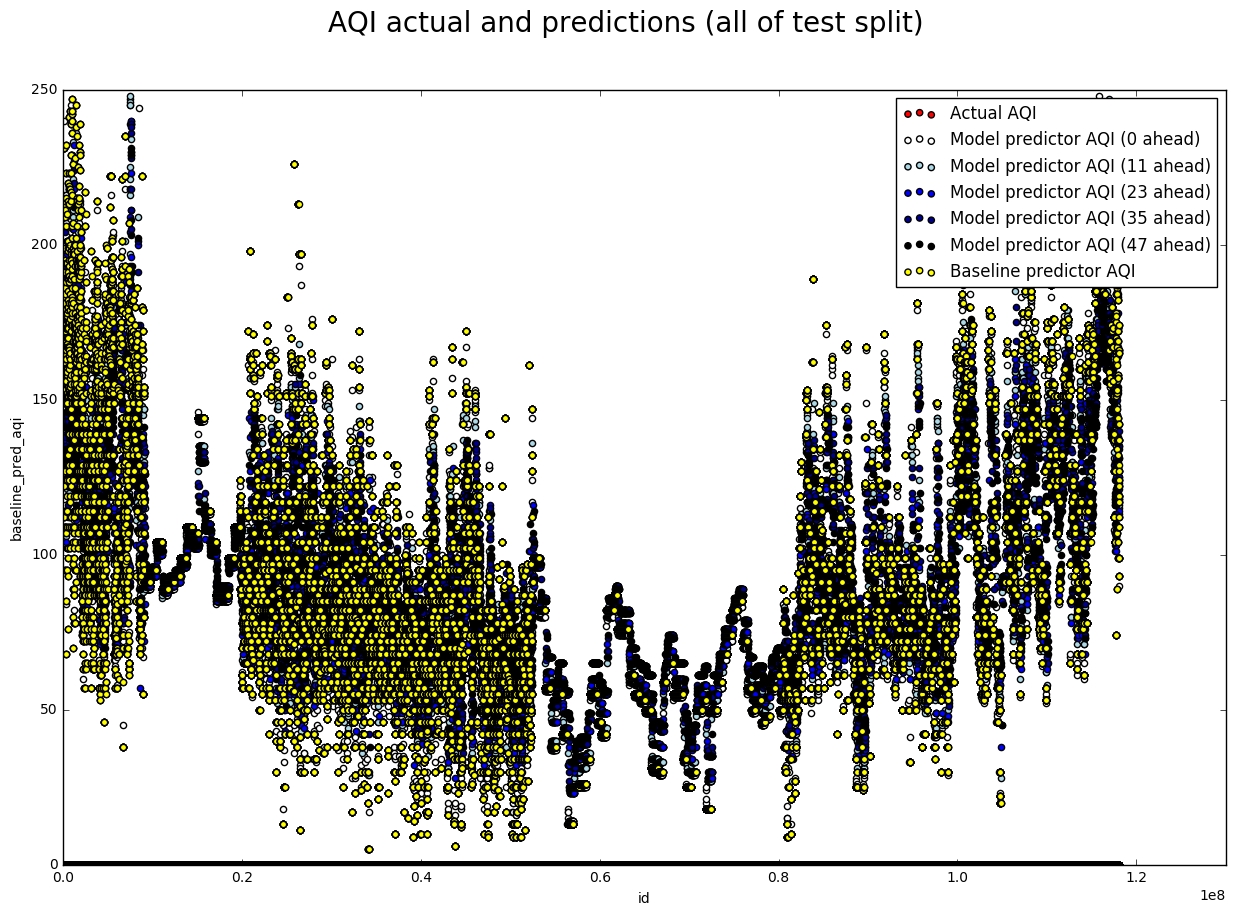

In [23]:
import matplotlib.pyplot as plt
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='0_ahead_pred', label="Model predictor AQI (0 ahead)", ax=aqi_graph, color="white")
test_results.plot.scatter(x='id', y='11_ahead_pred', label="Model predictor AQI (11 ahead)", ax=aqi_graph, color="lightblue")
test_results.plot.scatter(x='id', y='23_ahead_pred', label="Model predictor AQI (23 ahead)", ax=aqi_graph, color="blue")
test_results.plot.scatter(x='id', y='35_ahead_pred', label="Model predictor AQI (35 ahead)", ax=aqi_graph, color="darkblue")
test_results.plot.scatter(x='id', y='47_ahead_pred', label="Model predictor AQI (47 ahead)", ax=aqi_graph, color="black")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (all of test split)", fontsize=20)
aqi_graph.axis([0.0, 130000000.0, 0.0, 250.0])

In [31]:
def absolute_error_generator(compare_col):
    def absolute_error(row):
        return abs(row[compare_col] - row['aqi'])
    return absolute_error

test_results['0_ahead_pred_error'] = test_results.apply(absolute_error_generator('0_ahead_pred'), 1)
test_results['11_ahead_pred_error'] = test_results.apply(absolute_error_generator('11_ahead_pred'), 1)
test_results['23_ahead_pred_error'] = test_results.apply(absolute_error_generator('23_ahead_pred'), 1)
test_results['35_ahead_pred_error'] = test_results.apply(absolute_error_generator('35_ahead_pred'), 1)
test_results['47_ahead_pred_error'] = test_results.apply(absolute_error_generator('47_ahead_pred'), 1)
test_results['baseline_pred_aqi_error'] = test_results.apply(absolute_error_generator('baseline_pred_aqi'), 1)

[0.0, 130000000.0, 0.0, 250.0]

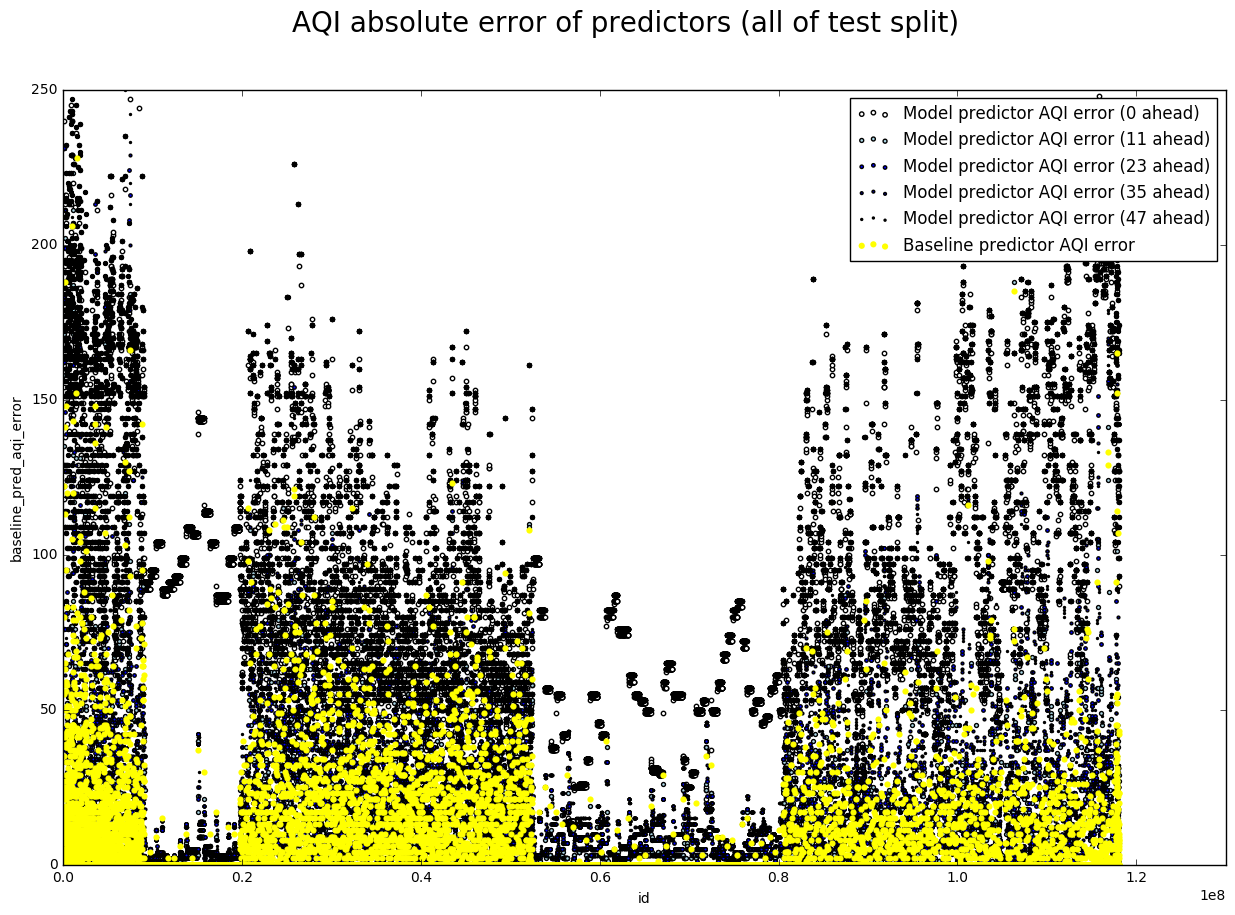

In [40]:
aqi_graph = test_results.plot.scatter(x='id', y='0_ahead_pred', label="Model predictor AQI error (0 ahead)", color="white", s=10, lw=1)
test_results.plot.scatter(x='id', y='11_ahead_pred_error', label="Model predictor AQI error (11 ahead)", ax=aqi_graph, color="lightblue", s=8, lw=1)
test_results.plot.scatter(x='id', y='23_ahead_pred_error', label="Model predictor AQI error (23 ahead)", ax=aqi_graph, color="blue", s=6, lw=1)
test_results.plot.scatter(x='id', y='35_ahead_pred_error', label="Model predictor AQI error (35 ahead)", ax=aqi_graph, color="darkblue", s=4, lw=1)
test_results.plot.scatter(x='id', y='47_ahead_pred_error', label="Model predictor AQI error (47 ahead)", ax=aqi_graph, color="black", s=2, lw=1)
test_results.plot.scatter(x='id', y='baseline_pred_aqi_error', label="Baseline predictor AQI error", ax=aqi_graph, color="Yellow", lw=0)
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI absolute error of predictors (all of test split)", fontsize=20)
aqi_graph.axis([0.0, 130000000.0, 0.0, 250.0])

[100000000.0, 120000000.0, 0.0, 250.0]

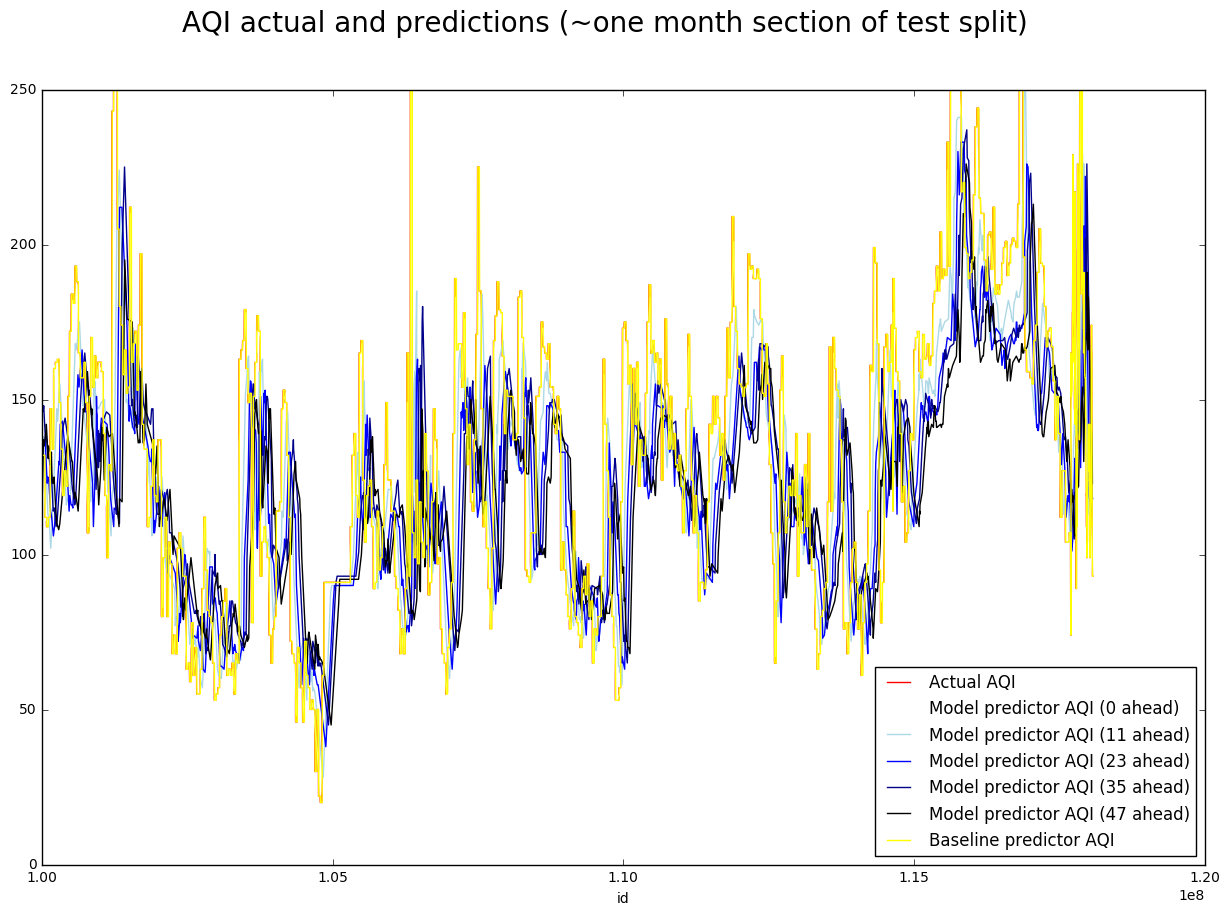

In [25]:
aqi_graph = test_results.plot(x='id', y='aqi', label="Actual AQI", color="Red")
test_results[test_results['0_ahead_pred'] != 0].plot(x='id', y='0_ahead_pred', label="Model predictor AQI (0 ahead)", ax=aqi_graph, color="white")
test_results[test_results['11_ahead_pred'] != 0].plot(x='id', y='11_ahead_pred', label="Model predictor AQI (11 ahead)", ax=aqi_graph, color="lightblue")
test_results[test_results['23_ahead_pred'] != 0].plot(x='id', y='23_ahead_pred', label="Model predictor AQI (23 ahead)", ax=aqi_graph, color="blue")
test_results[test_results['35_ahead_pred'] != 0].plot(x='id', y='35_ahead_pred', label="Model predictor AQI (35 ahead)", ax=aqi_graph, color="darkblue")
test_results[test_results['47_ahead_pred'] != 0].plot(x='id', y='47_ahead_pred', label="Model predictor AQI (47 ahead)", ax=aqi_graph, color="black")
test_results.plot(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (~one month section of test split)", fontsize=20)
aqi_graph.axis([100000000.0, 120000000.0, 0.0, 250.0])

[100000000.0, 103000000.0, 0.0, 250.0]

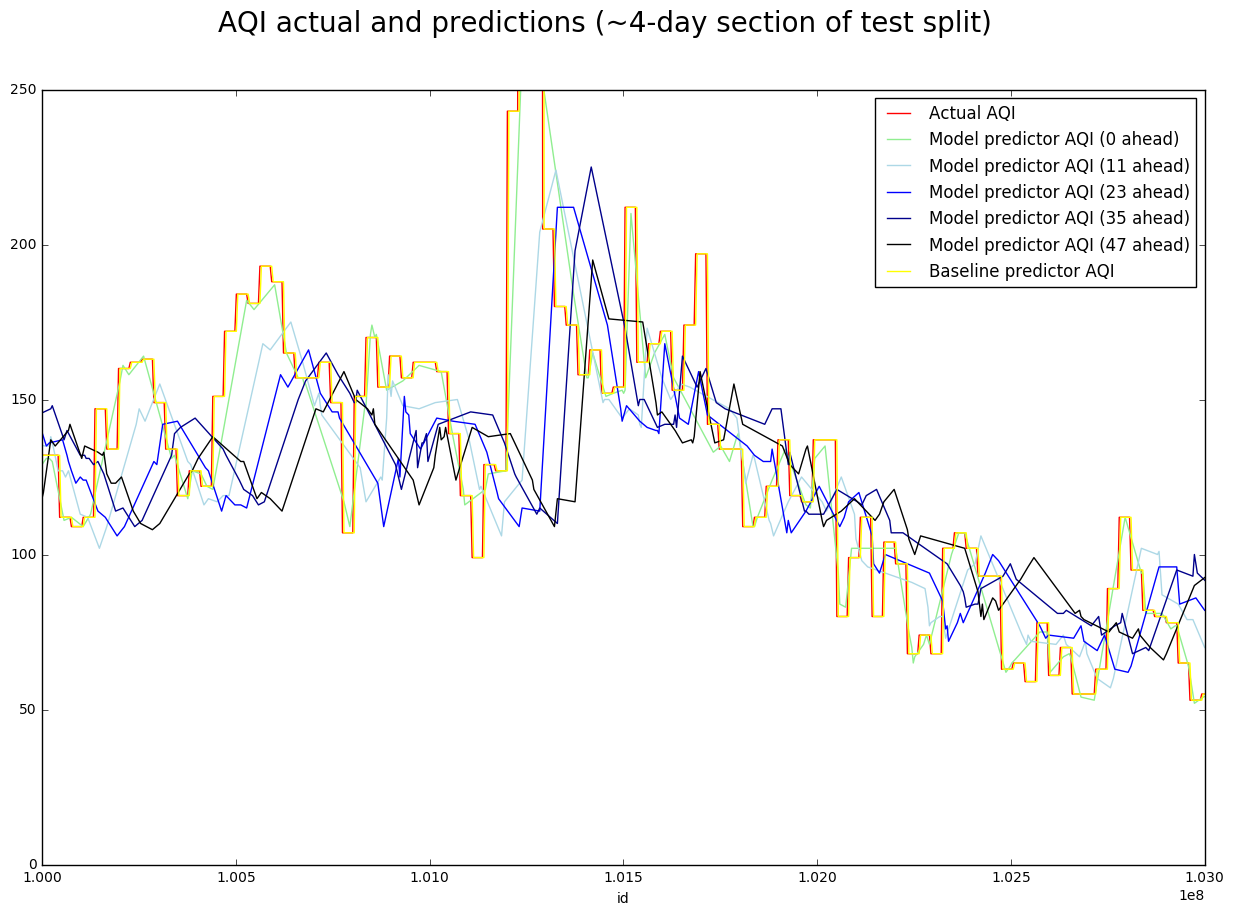

In [39]:
aqi_graph = test_results.plot(x='id', y='aqi', label="Actual AQI", color="Red")
test_results[test_results['0_ahead_pred'] != 0].plot(x='id', y='0_ahead_pred', label="Model predictor AQI (0 ahead)", ax=aqi_graph, color="lightgreen")
test_results[test_results['11_ahead_pred'] != 0].plot(x='id', y='11_ahead_pred', label="Model predictor AQI (11 ahead)", ax=aqi_graph, color="lightblue")
test_results[test_results['23_ahead_pred'] != 0].plot(x='id', y='23_ahead_pred', label="Model predictor AQI (23 ahead)", ax=aqi_graph, color="blue")
test_results[test_results['35_ahead_pred'] != 0].plot(x='id', y='35_ahead_pred', label="Model predictor AQI (35 ahead)", ax=aqi_graph, color="darkblue")
test_results[test_results['47_ahead_pred'] != 0].plot(x='id', y='47_ahead_pred', label="Model predictor AQI (47 ahead)", ax=aqi_graph, color="black")
test_results.plot(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (~4-day section of test split)", fontsize=20)
aqi_graph.axis([100000000.0, 103000000.0, 0.0, 250.0])